# Exam - Advanced Methods in Applied Statistics 2024 - Emilie Jessen

## Problem 5 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from iminuit import Minuit
import nestle

In [2]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

axes = {'facecolor': 'ghostwhite'}
mpl.rc('axes', **axes)

# Add grid
mpl.rc('axes', grid=True)

# Set custom color cycle
custom_colors= ['dodgerblue', 'red', 'limegreen', 'orange', 'orchid', 'black', 'slategrey', 
                'navy', 'magenta', 'forestgreen', 'lightblue', 'maroon', 'gold', 'lightcoral', 
                'mediumseagreen', 'darkorange', 'darkviolet', 'dimgray', 'darkblue', 'darkred',]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Set inside tickmarks
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [48]:
save_plots = True
np.random.seed(42)

### Problem 5a

In [49]:
data = np.array([[ 203.41 , -89.37 ],
                 [ 203.435, -94.88 ],
                 [ 203.46 , -101.25 ],
                 [ 203.484, -106.52 ],
                 [ 203.509, -108.66 ],
                 [ 203.534, -114.25 ],
                 [ 203.558, -114.30 ],
                 [ 203.583, -117.66 ],
                 [ 203.608, -122.45 ]])

sol = data[:,0]
temp = data[:,1]
temp_err = np.ones_like(temp) * 0.001

In [50]:
# Create linear and PCHIP spline for the data

f_lin = scipy.interpolate.interp1d(sol, temp, kind='linear')
f_pchip = scipy.interpolate.PchipInterpolator(sol, temp)

sol_axis = np.linspace(sol[0], sol[-1], 1000)
lin_spline = f_lin(sol_axis)
pchip_spline = f_pchip(sol_axis)

In [14]:
# Find value of the spline at the given point 
point = 203.570

lin_point = f_lin(point)
pchip_point = f_pchip(point)

# Print the values
print(f'Linear spline at {point}: {lin_point:.4f}')
print(f'PCHIP spline at {point}: {pchip_point:.4f}')

Linear spline at 203.57: -115.9128
PCHIP spline at 203.57: -115.4193


### Problem 5b

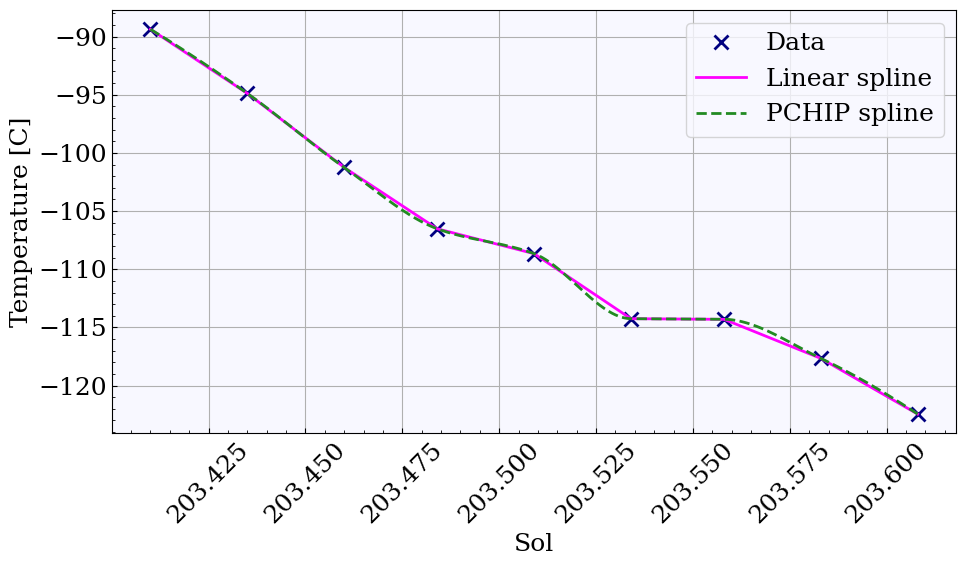

In [60]:
# Plot the data and the two interpolations

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(sol, temp, 'x', color='navy', ms=10, mew=2, label='Data')
ax.plot(sol_axis, lin_spline, color='magenta', lw=2, label='Linear spline')
ax.plot(sol_axis, pchip_spline, ls='--', color='forestgreen', lw=2, label='PCHIP spline')
ax.set_xlabel('Sol')
ax.set_ylabel('Temperature [C]')
ax.legend()

# Rotate x-axis labels
plt.xticks(rotation=45)

fig.tight_layout()

if save_plots:
    fig.savefig('Figures/Prob5_splines.pdf')

In [43]:
# Find out if the temperature is monotonically decreasing

lin_diff = np.diff(lin_spline)
pchip_diff = np.diff(pchip_spline)

# Check if the differences are negative
lin_decreasing = np.all(lin_diff < 0)
pchip_decreasing = np.all(pchip_diff < 0)

# Critical region for the differences
lin_critical = np.where(lin_diff > -0.005)[0]
pchip_critical = np.where(pchip_diff > -0.005)[0]

crit_min = sol_axis[lin_critical[0]]
crit_max = sol_axis[lin_critical[-1]]
crit_lin_max_val = np.max(lin_diff)
crit_pchip_max_val = np.max(pchip_diff)


print(f'Linear spline is monotonically decreasing: {lin_decreasing}')
print(f'PCHIP spline is monotonically decreasing: {pchip_decreasing}')

print(f'Aware of critical region for both splines: {crit_min:.3f} to {crit_max:.3f}')
print(f'Difference of linear spline max value in critical region: {crit_lin_max_val:.4f}')
print(f'Difference of PCHIP spline max value in critical region: {crit_pchip_max_val:.4f}')

Linear spline is monotonically decreasing: True
PCHIP spline is monotonically decreasing: True
Aware of critical region for both splines: 203.534 to 203.558
Difference of linear spline max value in critical region: -0.0004
Difference of PCHIP spline max value in critical region: -0.0002


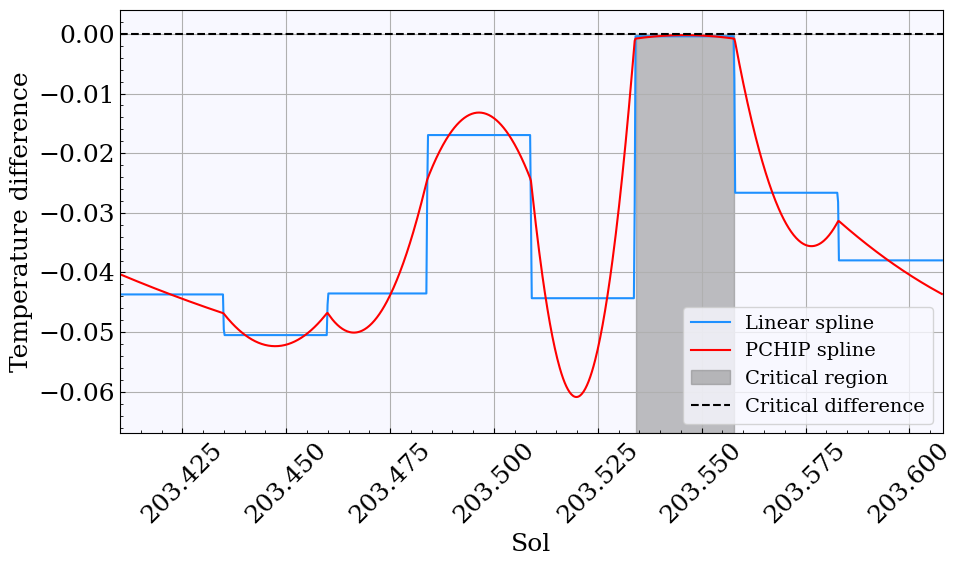

In [61]:
# Plot the differences

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(sol_axis[:-1], lin_diff, label='Linear spline')
ax.plot(sol_axis[:-1], pchip_diff, label='PCHIP spline')
ax.fill_between(sol_axis[lin_critical], np.min(pchip_diff)*1.1, 0.0, color='grey', alpha=0.5, label='Critical region')
ax.hlines(0, sol_axis[0], sol_axis[-1], linestyle='--', color='black', label='Critical difference')
ax.set_xlabel('Sol')
ax.set_ylabel('Temperature difference')
ax.set_xlim(sol_axis[0], sol_axis[-1])
ax.set_ylim(np.min(pchip_diff)*1.1, 0.004)
ax.legend(loc='lower right', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45)

fig.tight_layout()

if save_plots:
    fig.savefig('Figures/Prob5_spline_diff.pdf')

### Problem 5c

In [45]:
# Find if temperature changes of more than 0.09 C within 0.0004 sol

# Resultion of the sol
sol_res = 0.0004

# Maximum change 
temp_max = 0.09 

# High resolution array of sol values to evaulate the splines at
high_res_sol = np.arange(sol[0]+1e-4, sol[-1], sol_res)
lin_res = f_lin(high_res_sol)
pchip_res = f_pchip(high_res_sol)

# Find the absolute differences
lin_res_diff = np.diff(abs(lin_res))
pchip_res_diff = np.diff(abs(pchip_res))

# Check if any of the absolute differences are larger than the maximum temperature change
lin_temp_change = np.any(lin_res_diff > temp_max)
pchip_temp_change = np.any(pchip_res_diff > temp_max)

print(f'Linear spline has temperature changes larger than 0.09 C: {lin_temp_change}')
print(f'PCHIP spline has temperature changes larger than 0.09 C: {pchip_temp_change}')

Linear spline has temperature changes larger than 0.09 C: True
PCHIP spline has temperature changes larger than 0.09 C: True


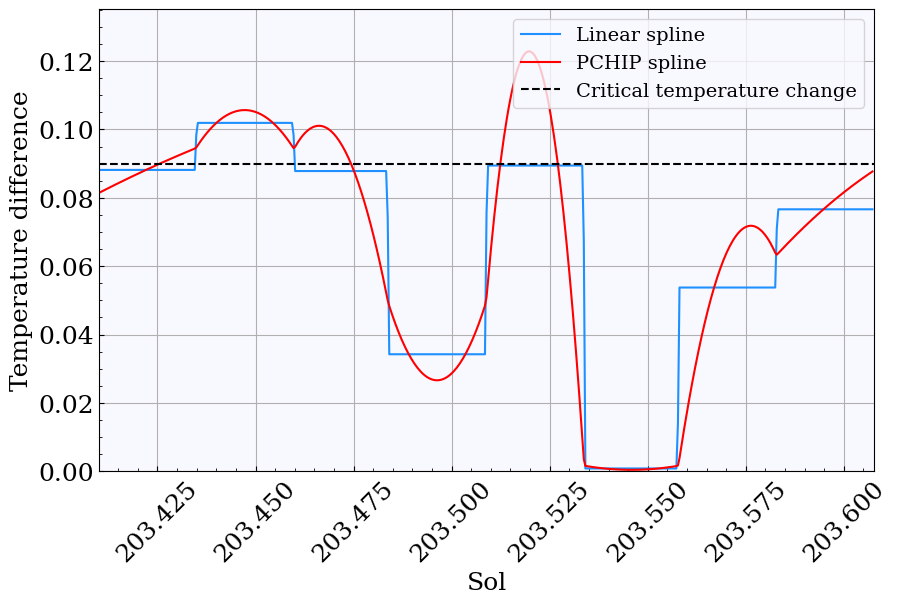

In [88]:
# Plot the absolute differences

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(high_res_sol[:-1], lin_res_diff, label='Linear spline')
ax.plot(high_res_sol[:-1], pchip_res_diff, label='PCHIP spline')
ax.hlines(temp_max, high_res_sol[0], high_res_sol[-1], linestyle='--', color='black', label='Critical temperature change')
ax.set_xlabel('Sol')
ax.set_ylabel('Temperature difference')
ax.set_xlim(high_res_sol[0], high_res_sol[-1])
ax.set_ylim(0.0, max(np.mean(lin_res_diff), np.max(pchip_res_diff))*1.1)
ax.legend(loc='upper right', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45)

if save_plots:
    fig.savefig('Figures/Prob5_abs_diff.pdf')